Philippe Joly 2025

# Exposition to Symbolic regression
## A ground up implementation of a genetic programming approach to symbolic regression

This serves as a complete implementation and illustration of a simple symbolic regression (SR)algorithm based on the genetic programming (GP) like mutations, crossovers, and natural selection. The notebook relies on the [**PySR**](https://arxiv.org/abs/2305.01582) library by Miles Cranmer and the [symbolic-regression-python](https://github.com/datarobot-community/symbolic-regression-python/tree/master) repository from *datarobot-community*

### Setup

In [183]:
import operator
import numpy as np
import matplotlib.pyplot as plt

from sympy import *
from random import randint, random, seed
from copy import deepcopy

In [184]:
# Seed used for reproducibility of the results for given functions. The functions themselves are not generated with this seed.
seed(0)

# Define global vars for the functions
TOURNAMENT_SZ, POP_SZ, CROSSOVER_RATE, COMBINE_RATE, MAX_GENERATIONS, REG, pop = 0,0,0,0,0,0,[]

### Generate Functions

Generate randomly distributed data from functions. These will be the functions we will want to infer!

In [185]:
# function definitions

## 1 dimensional functions
def f1_1(x, a, b, *args):
    return [a*x +b, f"{a}*x +{b}"]
def f1_2(x, a, b, c, *args):
    return [a*x**2 + b*x + c, f"{a}*x**2 + {b}*x + {c}"]
def f1_3(x, a, b, c, d, *args):    
    return [a*x**3 + b*x**2 + c*x + d, f"{a}*x**3 + {b}*x**2 + {c}*x + {d}"]
def f1_4(x, a, b, c, d, *args):
    return [a*np.sin(b*x+c)+d, f"{a}*sin({b}*x + {c}) + {d}"]
def f1_5(x, a, b, c, *args):
    return [a*np.exp(b*x)+c, f"{a}*exp({b}*x) + {c}"]

## 2 dimensional functions
def f2_1(x, y, a, b, c, *args):
    return [a*x + b*y + c, f"{a}*x + {b}*y + {c}"]
def f2_2(x, y, a, b, c, d, *args):
    return [a*x**2 + b*y**2 + c*x*y + d, f"{a}*x**2 + {b}*y**2 + {c}*x*y + {d}"]
def f2_3(x, y, a, b, c, d, e, *args):
    f = [f1_5(x, a, b, c), f1_5(y, d, e, 0)]
    return [f[0][0] + f[1][0], f[0][1] + "+"+ f[1][1]]
def f2_4(x, y, a, b, c, d, e, *args):
    return [a*np.sin(b*x)*np.exp(c*y)+d*x**2+e*x*y, f"{a}*sin({b}*x)*exp({c}*y) + {d}*x**2 + {e}*x*y"]

## 3 dimensional functions  
def f3_1(x, y, z, a, b, c, d, *args):
    return [a*x + b*y + c*z + d, f"{a}*x + {b}*y + {c}*z + {d}"]
def f3_2(x, y, z, a, b, *args):
    return [a*x**2 + b*y**2 + np.exp(z*y), f"{a}*x**2 + {b}*y**2 + exp(z*y)"]

linear_fxns = [
    [f1_1],
    [f2_1],
    [f3_1]
]
poly_fxns = [
    [f1_1, f1_2, f1_3],
    [f2_1, f2_2],
    [f3_1]
]
all_fxns = [
    [f1_1, f1_2, f1_3, f1_4, f1_5], 
    [f2_1, f2_2, f2_3, f2_4], 
    [f3_1, f3_2]
    ]


In [186]:
def generate_data(fxns, num_pts, num_per_f, sigma):
    X1 = np.linspace(-10, 10, num_pts[0]).reshape(-1,1)
    x = X1[:,0] 
    
    l2 = np.linspace(-10, 10, np.int16(np.sqrt(num_pts[1])))
    x2, y2 = np.meshgrid(l2,l2)
    X2 = np.column_stack([x2.ravel(), y2.ravel()])
    x2, y2 = X2[:,0], X2[:,1]

    l3 = np.linspace(-10, 10, np.int16(np.cbrt(num_pts[2])))
    x3, y3, z3 = np.meshgrid(l3,l3,l3) 
    X3 = np.column_stack([x3.ravel(), y3.ravel(), z3.ravel()])
    x3, y3, z3 = X3[:,0], X3[:,1], X3[:,2]

    data = []

    for num_input in range(len(fxns)):
        data.append([])
        for f in fxns[num_input]:
            for _ in range(num_per_f):
                # generate random coefficients
                a, b, c, d, e = np.random.randint(-4, 5, 5)

                # generate data from functions
                if num_input == 0:
                    ## only for homogeneous coeffs
                    b = 0 
                    data[-1].append(f(x, a, b, c, d, e))
                elif num_input == 1:
                    c =  0
                    data[-1].append(f(x2, y2, a, b, c, d, e))
                elif num_input == 2:
                    d = 0 
                    data[-1].append(f(x3, y3, z3, a, b, c, d, e))

                # Add gaussion noise
                noise = np.random.normal(loc=0, scale=sigma, size=data[-1][-1][0].shape)
                data[-1][-1][0] += noise

    return ([X1, X2, X3], data)

def print_fxns(data):
    in_vars = ["x", "x, y", "x, y, z"]
    for i, d in enumerate(data):
        print(f"Dimension {i+1}:")
        for j, f in enumerate(d):
            print(f"Function {j+1}: f({in_vars[i]}) = {f[1]}")
        print()

### Symbolic Regression Setup

This will be the setup of the data stuctures and genetic programming algorithms used in symbolic regression.

The expressions will be expressed as [**Binary Expression Trees**](https://en.wikipedia.org/wiki/Binary_expression_tree)

In [187]:
vals_1 = [
    {"var_name": "x", "var_idx": 0},
    {"var_name": "c", "var_idx": -1}
    ]
vals_2 = [
    {"var_name": "x","var_idx": 0}, 
    {"var_name": "y","var_idx": 1},
    {"var_name": "c", "var_idx": -1}
    ]
vals_3 = [
    {"var_name": "x","var_idx": 0}, 
    {"var_name": "y","var_idx": 1}, 
    {"var_name": "z","var_idx": 2},
    {"var_name": "c", "var_idx": -1}
    ]
vals = [vals_1, vals_2, vals_3]

def op_safe_div(x, y):
    return x/y if y else 0
def op_exp(x):
    return np.exp(x)
def op_sin(x):
    return np.sin(x)
def op_cos(x):
    return np.cos(x)
def op_pow(x, y):
    return operator.pow(x,y) if x else 0

complex_operations = [
    # {"op": op_safe_div, "arg_num": 2, "op_fmt": "({} / {})"},
    {"op": op_pow, "arg_num": 2, "op_fmt": "({}) ^ ({})"},
    # {"op": op_exp, "arg_num": 1, "op_fmt": "exp({})"},
    # {"op": op_sin, "arg_num": 1, "op_fmt": "sin({})"},
    # {"op": op_cos, "arg_num": 1, "op_fmt": "cos({})"}
]
simple_operations = [
    {"op": operator.add, "arg_num": 2, "op_fmt": "({} + {})"},
    {"op": operator.sub, "arg_num": 2, "op_fmt": "({} - {})"},
    {"op": operator.mul, "arg_num": 2, "op_fmt": "({} * {})"},
    {"op": operator.neg, "arg_num": 1, "op_fmt": "(-{})"},
]

operations = simple_operations + complex_operations

In [188]:
# The following will print and evaluate the operations from the binary expression tree starting from a root node (using recursion)

def render_ops(node):
    if "children" not in node:
        return node["var_name"] if node["var_name"] != "c" else node["value"]
    else:
        return node["op_fmt"].format(*[render_ops(c) for c in node["children"]])

def eval_ops(node, row):
    if "children" not in node:
        return node["value"] if node["var_name"] == "c" else row[node["var_idx"]]
    else:
        return node["op"](*[eval_ops(c, row) for c in node["children"]])
    

# Utility function to get number of nodes in the expression tree

def node_count(node):
    if "children" not in node:
        return 1 
    else:
        return sum([node_count(c) for c in node["children"]])


In [189]:
# The following converts sympy symbolic expression to binary expression trees
def sympy_to_tree(expr):
    var_idx = {
        'x': 0,
        'y': 1,
        'z': 2
    }
    operator_map = {
        Add: {"op": operator.add, "arg_num": 2, "op_fmt": "({} + {})"},
        Mul: {"op": operator.mul, "arg_num": 2, "op_fmt": "({} * {})"},
        Rational: {"op": op_safe_div, "arg_num": 2, "op_fmt": "({} / {})"},  
        lambda x, y: x - y: {"op": operator.sub, "arg_num": 2, "op_fmt": "({} - {})"},
        Pow: {"op": op_pow, "arg_num": 2, "op_fmt": "({}) ^ ({})"},
        lambda x: -x: {"op": operator.neg, "arg_num": 1, "op_fmt": "(-{})"},
        exp: {"op": op_exp, "arg_num": 1, "op_fmt": "exp({})"},
        sin: {"op": op_sin, "arg_num": 1, "op_fmt": "sin({})"},
        cos: {"op": op_cos, "arg_num": 1, "op_fmt": "cos({})"}
    }

    if expr.is_Symbol:
        var = str(expr)
        return {"var_name": var, "var_idx": var_idx[var]}
    elif expr.func in operator_map and len(expr.args)>0:
        node = deepcopy(operator_map[expr.func])
        num_args = len(expr.args)
        if num_args <= 2:
            node["children"] = [sympy_to_tree(arg) for arg in expr.args]
        else:
            args = list(expr.args)
            expr2 = expr.func(*args[1:])
            node["children"] = [sympy_to_tree(args[0]), sympy_to_tree(expr2)]
        return node
    else:
        try:
            value = float(expr.evalf())
        except:
            value = 0.
        return {"var_name": "c", "value": value, "var_idx": -1}

# This will simplify every function in the population using sympy
def simplify_pop(pop):
    new_pop = []
    for func in pop:
        sp_func = sympify(render_ops(func)).replace(lambda z: z.has(oo) or z.has(zoo), lambda z: 0)
        new_pop.append(sympy_to_tree(sympify(sp_func)))
        
    return new_pop

In [190]:
# The following will generate a random expression tree. 
# Notice that, as the depth increases, the probability of a leaf node increases as well.

def gen_random_func(depth, vals, simple=False):
    if randint(0, 5*2) >= depth *2:
        if simple:
            op = simple_operations[randint(0, len(simple_operations)-1)]
        else:
            op = operations[randint(0, len(operations)-1)]
        
        if op in complex_operations:
            simple = True
        
        new_op = deepcopy(op)
        new_op["children"]= [gen_random_func(depth+1, vals, simple=simple) for _ in range(op["arg_num"])]
        return new_op
    else:
        idx = randint(0, len(vals)-1)
        leaf = deepcopy(vals[idx])
        if idx == len(vals)-1:
            leaf["value"] = randint(-5,5)
        return leaf
    
    
# This recursive function will randomly select a node from the tree for processes like mutations or crossovers.
# Notice probability of selecting a node increasing with the depth of the node.

def get_random_node(node, parent, depth):
    if "children" not in node:
        return parent if parent is not None else node
    elif randint(0, 5*2) < depth *2:
        return node
    else:
        children_num = len(node["children"])
        return get_random_node(
            node["children"][randint(0, children_num-1)], 
            node, depth+1
            ) 

In [191]:
# The following will add 2 nodes together

def combine(node_1, node_2):
    new_node = deepcopy(simple_operations[0])
    new_node["children"] = [node_1, node_2]
    return new_node

# The following function will perform a mutation on a given node.
# It randomly replaces one of the children of the node with a new random function.

def mutate(node, vals):
    child = deepcopy(node)
    mutation_node = get_random_node(child, None, 0)

    if "children" in mutation_node:
        children_num = len(mutation_node["children"])
        mutation_node["children"][randint(0, children_num-1)] = gen_random_func(0, vals)
    else:
        mutation_node = gen_random_func(0, vals)

    return child


# The following function will perform a crossover between two nodes.
# It randomly replaces one of the first parent's subtrees with the selected subtree from the second parent.

def crossover(node_1, node_2):
    child = deepcopy(node_1)
    cross_1 = get_random_node(child, None, 0)
    cross_2 = get_random_node(node_2, None, 0)

    if "children" in cross_1 :
        children_num = len(cross_1["children"])
        cross_1["children"][randint(0, children_num-1)] = cross_2
    else:
        cross_1 = cross_2

    return child

In [192]:
# The following function will evaluate the fitness of a given function.
# We choose to use the mean squared error loss function as the fitness function, penalized by the complexity of the function.

def get_fitness(func, func_preds, f_data):
    func_preds = np.asarray(func_preds, dtype=np.float64)
    
    if np.count_nonzero(np.isnan(func_preds))>func_preds.shape[0]/10:
        return -1

    mse = np.nanmean((func_preds - f_data)**2)
    complexity_penalty = node_count(func) ** REG

    return mse * complexity_penalty

In [193]:
# The following function will generate a random subset of the population, and, from that, it will return the function with the lowest fitess.

def get_random_func(pop, fitness):
    tournament_funcs = [
        randint(0, POP_SZ-1) for _ in range(TOURNAMENT_SZ)
        ]
    funcs_fitness = [
        (fitness[i], pop[i]) for i in tournament_funcs
        ]
    
    return min(funcs_fitness, key=lambda x: x[0])[1]


# The following function will generate a child function from the population.
# It will randomly select a parent function (decided in tournament fashion), and, with a given probability, it will perform a mutation or a crossover with another parent function.

def get_child(pop, fitness, vals):
    parent_1 = get_random_func(pop, fitness)

    if random() < COMBINE_RATE:
        parent_2 = get_random_func(pop, fitness)
        return combine(parent_1, parent_2)
    if random() < CROSSOVER_RATE:
        parent_2 = get_random_func(pop, fitness)
        return crossover(parent_1, parent_2)
    else:
        return mutate(parent_1, vals)

### Symbolic Regression Implementation

This is the main loop for symbolic regression.

In [194]:
# Plot infered function and actual function

def compare_3d_plot(X, preds, data):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': '3d'})
    
    ax1.set_title("Actual Function")
    ax1.plot_trisurf(X[:,0], X[:,1], data, cmap="viridis", alpha=0.7)
    ax2.set_title("Symbolic Regression Prediction")
    ax2.plot_trisurf(X[:,0], X[:,1], preds, cmap="plasma", alpha=0.7)

    ax1.set_xlabel("X")
    ax1.set_ylabel("Y")
    ax1.set_label("Z")
    ax2.set_xlabel("X")
    ax2.set_ylabel("Y")
    ax2.set_label("Z")

    plt.tight_layout()
    plt.show()

In [195]:
TOURNAMENT_SZ = 5
POP_SZ = 100
CROSSOVER_RATE = 0.4
COMBINE_RATE = 0.4
DROPOUT_RATE = 0.1
KEEP_RATE = 0.05
MAX_GENERATIONS = 20
REG = 0.2
CONVERGENCE_RAD = 1

In [196]:
X, data = generate_data(poly_fxns, num_pts=[100, 100**2, 21**3], num_per_f=1, sigma=0.1)

print_fxns(data)

Dimension 1:
Function 1: f(x) = 3*x +0
Function 2: f(x) = -3*x**2 + 0*x + 2
Function 3: f(x) = -1*x**3 + 0*x**2 + -2*x + 3

Dimension 2:
Function 1: f(x, y) = -1*x + -1*y + 0
Function 2: f(x, y) = 4*x**2 + 1*y**2 + 0*x*y + -3

Dimension 3:
Function 1: f(x, y, z) = -2*x + 0*y + -1*z + 0



In [197]:
num_input = 1
X_f = X[num_input]
data_f = data[num_input][randint(0, len(data[num_input]))][0]
f =  data[num_input][randint(0, len(data[num_input]))][1]

pop = simplify_pop([gen_random_func(0, vals[num_input]) for _ in range(POP_SZ)]) 

In [198]:
sympify(f)

4*x**2 + y**2 - 3

In [199]:
global_best = float("inf")

for gen in range(MAX_GENERATIONS):
    fitness = []
    for i, func in enumerate(pop):
        preds = np.array([eval_ops(func, row) for row in X_f])

        fit_score = get_fitness(func, preds, data_f)
        if np.isnan(fit_score) or fit_score<0 or not np.isreal(fit_score):
            pop[i] = gen_random_func(0, vals[num_input])
            preds = np.array([eval_ops(pop[i], row) for row in X_f])
            fit_score = get_fitness(pop[i], preds, data_f)
        fitness.append(fit_score)

        if fit_score < global_best and fit_score >= 0:
            global_best = fit_score
            best_pred = preds
            best_func = pop[i]
     
    print(f"Generation {gen+1} Complete: Best func {sympify(render_ops(best_func))} with fitness {global_best}")
    if global_best<CONVERGENCE_RAD:
        break

    smallest_fitness = np.argpartition(np.array(fitness), int(POP_SZ*KEEP_RATE))[:int(POP_SZ*KEEP_RATE)]
    # print(smallest_fitness)
    pop = simplify_pop(
        [pop[k] for k in smallest_fitness]
        + [gen_random_func(0, vals[num_input]) for _ in range(int(POP_SZ*DROPOUT_RATE))]
        +[get_child(pop, fitness, vals[num_input]) for _ in range(int(POP_SZ*(1-DROPOUT_RATE-KEEP_RATE)))]
        )

C:\Users\philj\AppData\Local\Temp\ipykernel_8924\3545370445.py:27: RuntimeWarning: invalid value encountered in scalar power
  return operator.pow(x,y) if x else 0
C:\Users\philj\AppData\Local\Temp\ipykernel_8924\3545370445.py:27: RuntimeWarning: overflow encountered in scalar power
  return operator.pow(x,y) if x else 0


Generation 1 Complete: Best func 5.0*x*(x + 4.0) + x**2.0 + y with fitness 28969.53378895074


C:\Users\philj\AppData\Local\Temp\ipykernel_8924\7060370.py:13: RuntimeWarning: overflow encountered in scalar multiply
  return node["op"](*[eval_ops(c, row) for c in node["children"]])


Generation 2 Complete: Best func 4*x**2 with fitness 2488.981487178871
Generation 3 Complete: Best func 4*x**2 with fitness 2488.981487178871
Generation 4 Complete: Best func 4*x**2 with fitness 2488.981487178871
Generation 5 Complete: Best func 4*x**2 with fitness 2488.981487178871


C:\Users\philj\AppData\Local\Temp\ipykernel_8924\999938645.py:10: RuntimeWarning: overflow encountered in square
  mse = np.nanmean((func_preds - f_data)**2)


Generation 6 Complete: Best func 4*x**2 with fitness 2488.981487178871
Generation 7 Complete: Best func 4*x**2 with fitness 2488.981487178871
Generation 8 Complete: Best func 4*x**2 with fitness 2488.981487178871


C:\Users\philj\AppData\Local\Temp\ipykernel_8924\7060370.py:13: RuntimeWarning: invalid value encountered in scalar multiply
  return node["op"](*[eval_ops(c, row) for c in node["children"]])


Generation 9 Complete: Best func 4.0*x**2.0 - 2.0*y + 6.0 with fitness 2412.9488477723885
Generation 10 Complete: Best func 4.0*x**2.0 - 2.0*y + 6.0 with fitness 2412.9488477723885
Generation 11 Complete: Best func 4.0*x**2.0 - 2.0*y + 6.0 with fitness 2412.9488477723885
Generation 12 Complete: Best func 4.0*x**2.0 - 2.0*y + 6.0 with fitness 2412.9488477723885
Generation 13 Complete: Best func 4.0*x**2.0 - 2.0*y + 6.0 with fitness 2412.9488477723885
Generation 14 Complete: Best func 4.0*x**2.0 - 2.0*y + 6.0 with fitness 2412.9488477723885
Generation 15 Complete: Best func 4.0*x**2.0 - 2.0*y + 6.0 with fitness 2412.9488477723885
Generation 16 Complete: Best func 4.0*x**2.0 - 2.0*y + 6.0 with fitness 2412.9488477723885
Generation 17 Complete: Best func 4.0*x**2.0 - 2.0*y + 6.0 with fitness 2412.9488477723885
Generation 18 Complete: Best func 4.0*x**2.0 - 2.0*y + 6.0 with fitness 2412.9488477723885
Generation 19 Complete: Best func 4.0*x**2.0 - 2.0*y + 6.0 with fitness 2412.9488477723885


In [200]:
print("Best Global Score: %.2f" % (global_best))
print("Best Function:", sympify(render_ops(best_func)))
print("Actual Function:", sympify(f))

Best Global Score: 2412.95
Best Function: 4.0*x**2.0 - 2.0*y + 6.0
Actual Function: 4*x**2 + y**2 - 3


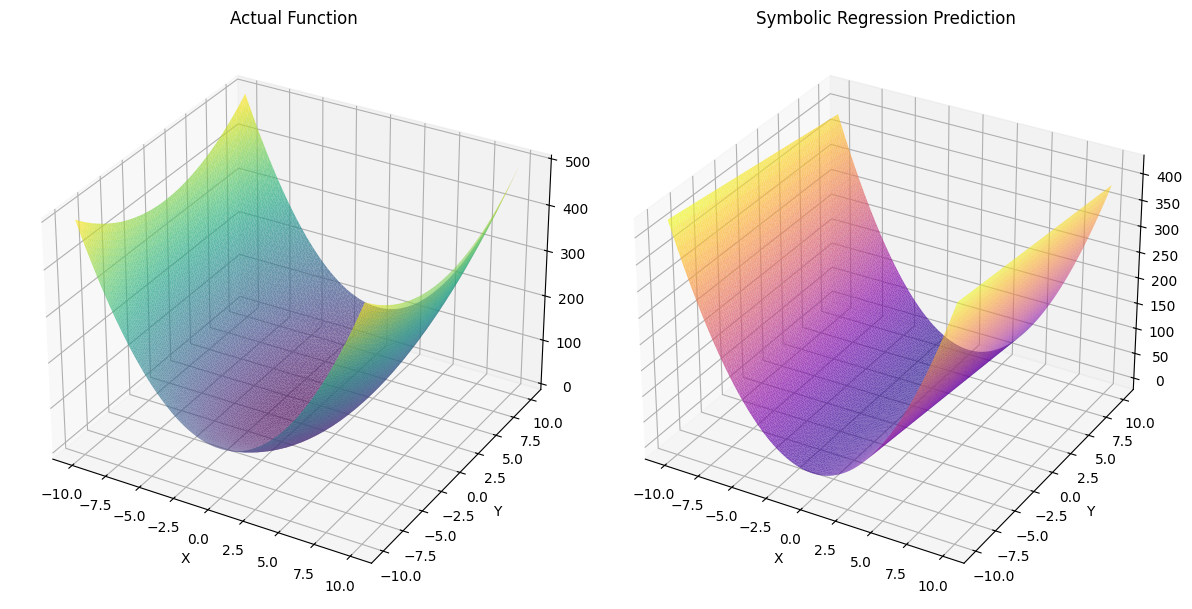

In [201]:
compare_3d_plot(X_f, best_pred, data_f)